In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import RMSprop, Adam, Optimizer, Optimizer, Adagrad
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D, BatchNormalization, \
    Permute, TimeDistributed, Bidirectional, GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D
import tensorflow as tf
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=UserWarning)

In [8]:
# папки
train_path = list(Path("./Parkinson's Drawings/spiral/training").glob(r"*/*.png"))
test_path = list(Path("./Parkinson's Drawings/spiral/testing").glob(r"*/*.png"))
# метки
train_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], train_path))
test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_path))
# датафрейм
train_data = pd.concat([pd.Series(train_path, name="PNG").astype(str), pd.Series(train_labels, name="CATEGORY")], axis=1)
test_data = pd.concat([pd.Series(test_path, name="PNG").astype(str), pd.Series(test_labels, name="CATEGORY")], axis=1)
# перемешивание
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

### Изображения тренировочного набора

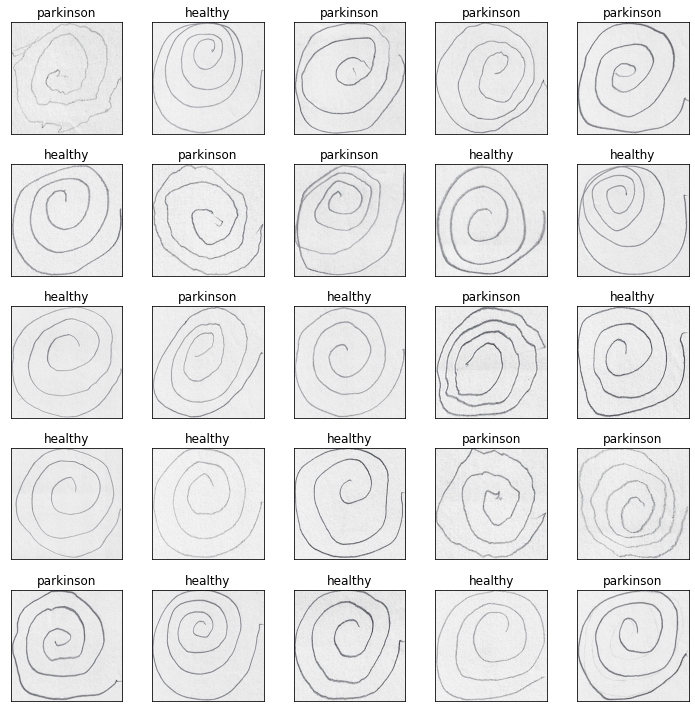

In [9]:
# общая картинка
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_data["PNG"][i]))
    ax.set_title(train_data["CATEGORY"][i])
plt.tight_layout()
plt.show()

### Изображения тестового набора

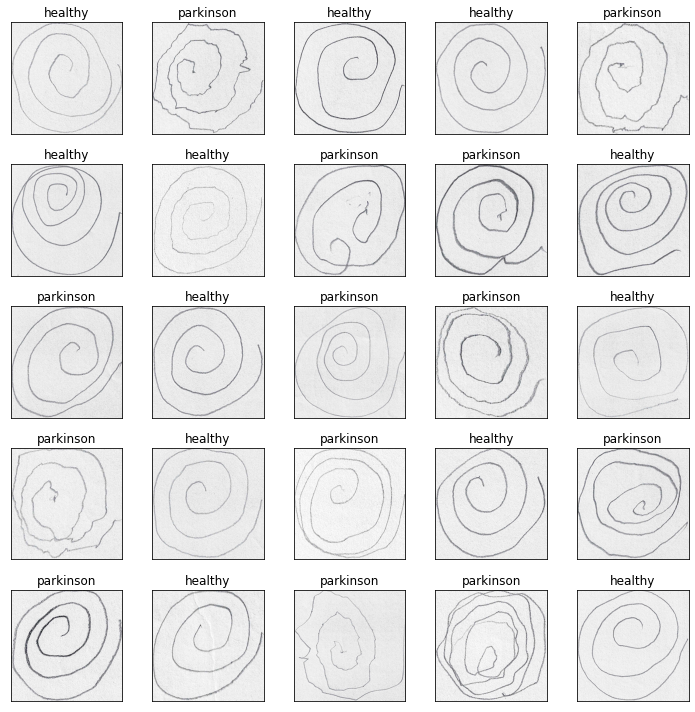

In [10]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10,10), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_data["PNG"][i]))
    ax.set_title(test_data["CATEGORY"][i])
plt.tight_layout()
plt.show()

### Тренировка и тестирование на датасете

In [61]:
# трансформация
path = []
for i in range(0, 72):
    path.append(np.array(cv2.imread(train_data["PNG"][i])).astype("float32").mean()/255)

train = pd.concat([pd.Series(path, name="PNG"), pd.Series(LabelEncoder().fit_transform(train_data["CATEGORY"]), name="CATEGORY")], axis=1)

path = []
for i in range(0, 30):
    path.append(np.array(cv2.imread(test_data["PNG"][i])).astype("float32").mean()/255)

test = pd.concat([pd.Series(path, name="PNG"), pd.Series(LabelEncoder().fit_transform(test_data["CATEGORY"]), name="CATEGORY")], axis=1)
# тренировка и тестирование
xTrain, xTest, yTrain, yTest = train_test_split(pd.concat([train,test])[["PNG"]], pd.concat([train,test])["CATEGORY"], test_size=0.2, random_state=42)
#xTrain, yTrain, xTest, yTest = train[["PNG"]], train["CATEGORY"], test[["PNG"]], test["CATEGORY"]
models = [LogisticRegression(solver="liblinear").fit(xTrain, yTrain),
           GaussianNB().fit(xTrain, yTrain),
           KNeighborsClassifier().fit(xTrain, yTrain),
           DecisionTreeClassifier().fit(xTrain, yTrain),
           RandomForestClassifier(verbose=False).fit(xTrain, yTrain),
           GradientBoostingClassifier(verbose=False).fit(xTrain, yTrain),
           XGBClassifier().fit(xTrain, yTrain),
           LGBMClassifier().fit(xTrain, yTrain),
           CatBoostClassifier(verbose=False).fit(xTrain, yTrain)]
table_acc = pd.DataFrame(columns=['model','accuracy','sensitivity','specificity'])
i = 0
for model in models:
    predict = model.predict(xTest)
    cm = confusion_matrix(yTest, predict).ravel()
    tn, fp, fn, tp = cm
    accuracy = (tp + tn) / float(cm.sum())
    sensitivity = tp / float(tp + fn)
    specificity = tn / float(tn + fp)
    #table_acc.loc[i] = [model.__class__.__name__, accuracy_score(yTest, predict)]
    table_acc.loc[i] = [model.__class__.__name__, accuracy, sensitivity, specificity]
    i += 1
table_acc

[16:52:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,model,accuracy,sensitivity,specificity
0,LogisticRegression,0.380952,0.000000,1.000
1,GaussianNB,0.428571,0.153846,0.875
2,KNeighborsClassifier,0.571429,0.307692,1.000
3,DecisionTreeClassifier,0.619048,0.538462,0.750
4,RandomForestClassifier,0.619048,0.538462,0.750
5,GradientBoostingClassifier,0.619048,0.538462,0.750
6,XGBClassifier,0.523810,0.384615,0.750
7,LGBMClassifier,0.619048,0.384615,1.000
8,CatBoostClassifier,0.476190,0.230769,0.875


### Генерация новых изображений

In [12]:
# генерация изображения
generator = ImageDataGenerator(rescale=1./255, #показатель масштабирования данных
                                    #zoom_range=0.7, #Диапазон случайного выбора масштабирования изображения.
                                    shear_range=0.7, #диапазон сдвига пикселей изображения
                                    rotation_range=50, #поворот изображения в градусах
                                    horizontal_flip=True,
                                    #brightness_range=[0.4, 0.6], #диапазон выбора сдвига по яркости
                                    vertical_flip=True)


train_data_generate = generator.flow_from_dataframe(dataframe=train_data,
                                                   x_col="PNG",
                                                   y_col="CATEGORY",
                                                   batch_size = 72,
                                                   shuffle=False,
                                                   class_mode="categorical",
                                                   subset="training")

test_data_generate = generator.flow_from_dataframe(dataframe=test_data,
                                                   x_col="PNG",
                                                   y_col="CATEGORY",
                                                   batch_size = 30,
                                                   shuffle=False,
                                                   class_mode="categorical")
# трансформация
path = []
for i in range(0, 72):
    path.append(train_data_generate[0][0][i].mean())

train_generate = pd.concat([pd.Series(path, name="PNG"), pd.Series(train_data_generate.classes, name="CATEGORY")], axis=1)

path = []
for i in range(0, 30):
    path.append(test_data_generate[0][0][i].mean())

test_generate = pd.concat([pd.Series(path, name="PNG"), pd.Series(test_data_generate.classes, name="CATEGORY")], axis=1)

Found 72 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


### Сгенерированные изображения тренировочного набора

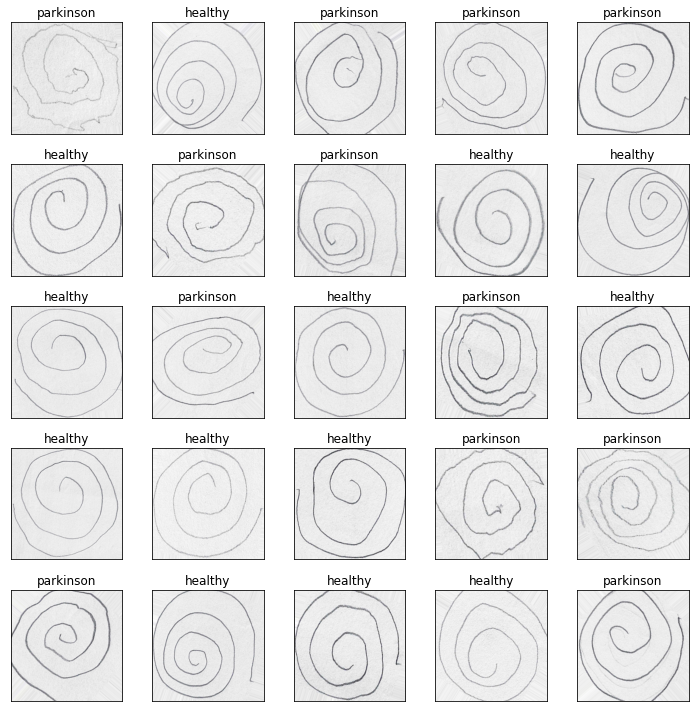

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(train_data_generate[0][0][i])
    ax.set_title('parkinson' if train_data_generate.classes[i] == 1 else 'healthy')
plt.tight_layout()
plt.show()

### Сгенерированные изображения тестового набора

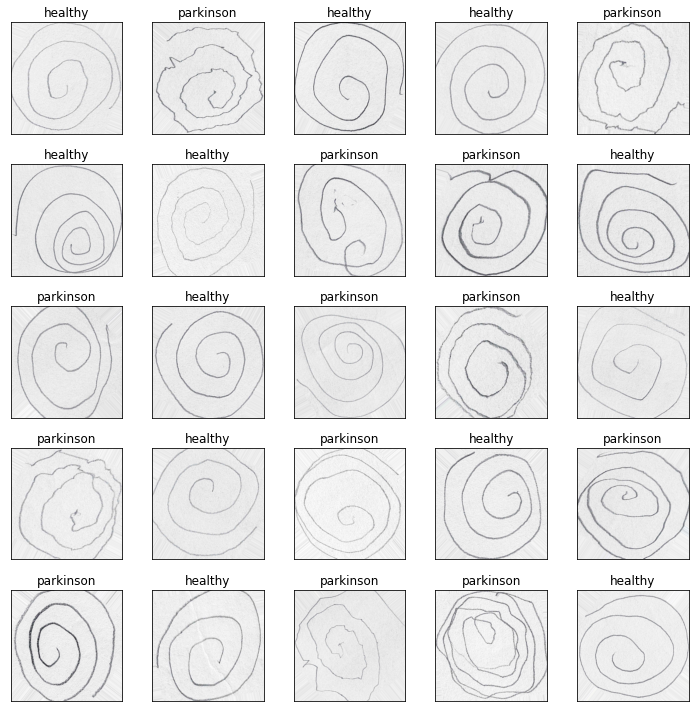

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(test_data_generate[0][0][i])
    ax.set_title('parkinson' if test_data_generate.classes[i] == 1 else 'healthy')
plt.tight_layout()
plt.show()

### Тренировка и тестирование на сгенерированных изображениях

In [60]:
# тренировка и тестирование
xTrain, xTest, yTrain, yTest = train_test_split(pd.concat([train_generate,test_generate])[["PNG"]], pd.concat([train_generate,test_generate])["CATEGORY"], test_size=0.2, random_state=42)
#xTrain, yTrain, xTest, yTest = train_generate[["PNG"]], train_generate["CATEGORY"], test_generate[["PNG"]], test_generate["CATEGORY"]
models = [LogisticRegression(solver="liblinear").fit(xTrain, yTrain),
           GaussianNB().fit(xTrain, yTrain),
           KNeighborsClassifier().fit(xTrain, yTrain),
           DecisionTreeClassifier().fit(xTrain, yTrain),
           RandomForestClassifier(verbose=False).fit(xTrain, yTrain),
           GradientBoostingClassifier(verbose=False).fit(xTrain, yTrain),
           XGBClassifier().fit(xTrain, yTrain),
           LGBMClassifier().fit(xTrain, yTrain),
           CatBoostClassifier(verbose=False).fit(xTrain, yTrain)]
table_acc = pd.DataFrame(columns=['model','accuracy','sensitivity','specificity'])
i = 0
for model in models:
    predict = model.predict(xTest)
    cm = confusion_matrix(yTest, predict).ravel()
    tn, fp, fn, tp = cm
    accuracy = (tp + tn) / float(cm.sum())
    sensitivity = tp / float(tp + fn)
    specificity = tn / float(tn + fp)
    #table_acc.loc[i] = [model.__class__.__name__, accuracy_score(yTest, predict)]
    table_acc.loc[i] = [model.__class__.__name__, accuracy, sensitivity, specificity]
    i += 1
table_acc

[16:52:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,model,accuracy,sensitivity,specificity
0,LogisticRegression,0.380952,0.000000,1.000
1,GaussianNB,0.476190,0.230769,0.875
2,KNeighborsClassifier,0.523810,0.230769,1.000
3,DecisionTreeClassifier,0.571429,0.615385,0.500
4,RandomForestClassifier,0.571429,0.615385,0.500
5,GradientBoostingClassifier,0.523810,0.538462,0.500
6,XGBClassifier,0.571429,0.538462,0.625
7,LGBMClassifier,0.523810,0.230769,1.000
8,CatBoostClassifier,0.523810,0.461538,0.625


### Тренировка и тестирование на всех данных

In [58]:
# тренировка и тестирование
xTrain, xTest, yTrain, yTest = train_test_split(pd.concat([train,test,train_generate,test_generate])[["PNG"]], pd.concat([train,test,train_generate,test_generate])["CATEGORY"], test_size=0.2, random_state=42)
#xTrain, yTrain, xTest, yTest = pd.concat([train,train_generate])[["PNG"]], pd.concat([train,train_generate])["CATEGORY"], pd.concat([test,test_generate])[["PNG"]], pd.concat([test,test_generate])["CATEGORY"]
models = [LogisticRegression(solver="liblinear").fit(xTrain, yTrain),
           GaussianNB().fit(xTrain, yTrain),
           KNeighborsClassifier().fit(xTrain, yTrain),
           DecisionTreeClassifier().fit(xTrain, yTrain),
           RandomForestClassifier(verbose=False).fit(xTrain, yTrain),
           GradientBoostingClassifier(verbose=False).fit(xTrain, yTrain),
           XGBClassifier().fit(xTrain, yTrain),
           LGBMClassifier().fit(xTrain, yTrain),
           CatBoostClassifier(verbose=False).fit(xTrain, yTrain)]
table_acc = pd.DataFrame(columns=['model','accuracy','sensitivity','specificity'])
i = 0
for model in models:
    predict = model.predict(xTest)
    cm = confusion_matrix(yTest, predict).ravel()
    tn, fp, fn, tp = cm
    accuracy = (tp + tn) / float(cm.sum())
    sensitivity = tp / float(tp + fn)
    specificity = tn / float(tn + fp)
    #table_acc.loc[i] = [model.__class__.__name__, accuracy_score(yTest, predict)]
    table_acc.loc[i] = [model.__class__.__name__, accuracy, sensitivity, specificity]
    i += 1
table_acc

[16:51:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,model,accuracy,sensitivity,specificity
0,LogisticRegression,0.463415,0.000000,1.000000
1,GaussianNB,0.536585,0.363636,0.736842
2,KNeighborsClassifier,0.609756,0.636364,0.578947
3,DecisionTreeClassifier,0.560976,0.636364,0.473684
4,RandomForestClassifier,0.560976,0.636364,0.473684
5,GradientBoostingClassifier,0.585366,0.636364,0.526316
6,XGBClassifier,0.560976,0.636364,0.473684
7,LGBMClassifier,0.560976,0.500000,0.631579
8,CatBoostClassifier,0.682927,0.727273,0.631579
